In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights

from lime_ieinn import ImageExplainer
from skimage.segmentation import mark_boundaries

C:\Users\minas\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
def crop_center_square(img: Image.Image) -> Image.Image:
    w, h = img.size
    min_edge = min(w, h)
    left = (w - min_edge) // 2
    top = (h - min_edge) // 2
    right = left + min_edge
    bottom = top + min_edge
    return img.crop((left, top, right, bottom))

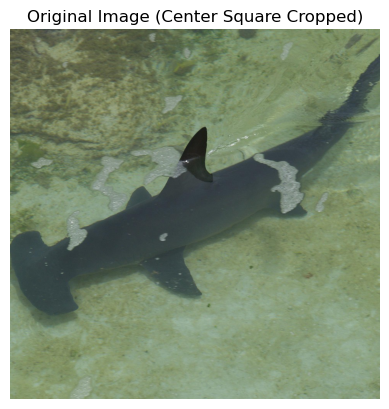

In [3]:
original_image = Image.open("./data/hammerhead2.jpg").convert("RGB")
image = crop_center_square(original_image)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image (Center Square Cropped)")
plt.show()

In [4]:
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
model.eval()

preprocess = transforms.Compose([ 
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [5]:
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(LABELS_URL).text.strip().split("\n")

In [6]:
def predict_fn(images_np):
    images = torch.from_numpy(images_np).permute(0, 3, 1, 2).float() / 255.0
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = torch.stack([normalize(img) for img in images])
    with torch.no_grad():
        outputs = model(images)
    return outputs.softmax(dim=1).cpu().numpy()

In [7]:
explainer = ImageExplainer(kernel_width=0.25, additivity_order=2, epochs=1000)

explanation = explainer.explain_instance(
    np.array(image),
    predict_fn,
    num_samples=1000,
    num_features=100,
    grid_size=4
)

probs = predict_fn(np.expand_dims(np.array(image), axis=0))
top_label = int(np.argmax(probs))
top_class = imagenet_classes[top_label]

print(f"described label: {top_label} - {top_class}")

Epoch [1/1000], loss: 3.04204580 val_loss: 0.11249326
Epoch [2/1000], loss: 0.30858289 val_loss: 0.24579355
Epoch [3/1000], loss: 0.13788864 val_loss: 0.07760748
Epoch [4/1000], loss: 0.08688875 val_loss: 0.07547201
Epoch [5/1000], loss: 0.07175268 val_loss: 0.06429663
Epoch [6/1000], loss: 0.07118353 val_loss: 0.06382002
Epoch [7/1000], loss: 0.06363903 val_loss: 0.06326050
Epoch [8/1000], loss: 0.06518573 val_loss: 0.06367422
Epoch [9/1000], loss: 0.06194413 val_loss: 0.05673835
Epoch [10/1000], loss: 0.06191379 val_loss: 0.05550585
Epoch [11/1000], loss: 0.05967990 val_loss: 0.05449672
Epoch [12/1000], loss: 0.06351489 val_loss: 0.05234402
Epoch [13/1000], loss: 0.06335493 val_loss: 0.05519710
Epoch [14/1000], loss: 0.07142299 val_loss: 0.09416402
Epoch [15/1000], loss: 0.07143975 val_loss: 0.05345872
Epoch [16/1000], loss: 0.05691877 val_loss: 0.04915332
Epoch [17/1000], loss: 0.05263402 val_loss: 0.05226976
Epoch [18/1000], loss: 0.05066402 val_loss: 0.04988744
Epoch [19/1000], lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


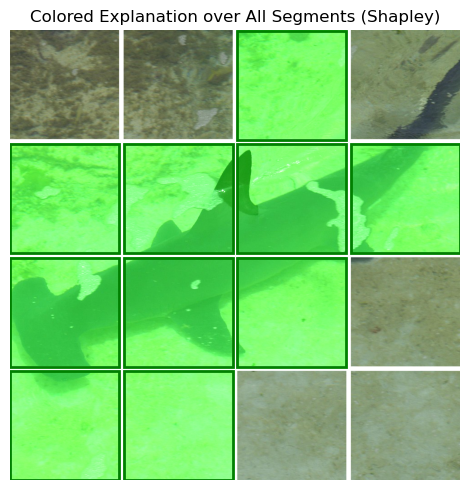

In [8]:
explanation.plot_colored_segment_tiles(top_k=10)

C:\Users\minas\研究\LIME+IEINN\lime_ieinn\lime_ieinn\explanation.py:222: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=13)


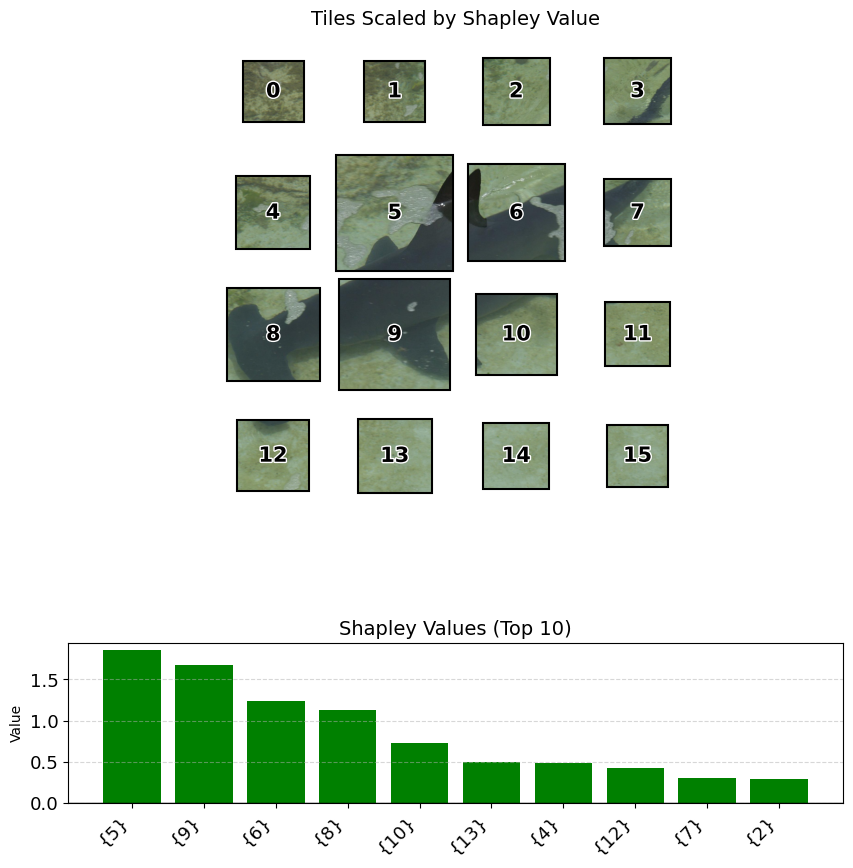

In [9]:
explanation.plot(mode="shapley")

C:\Users\minas\研究\LIME+IEINN\lime_ieinn\lime_ieinn\explanation.py:222: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=13)


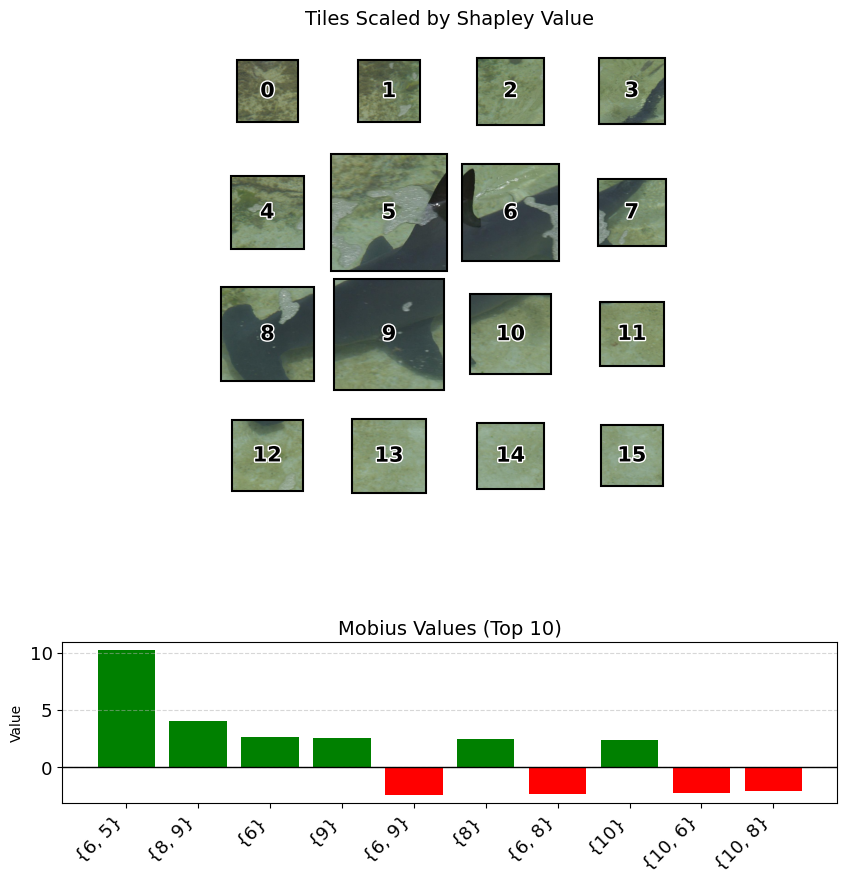

In [10]:
explanation.plot(mode="mobius")

C:\Users\minas\研究\LIME+IEINN\lime_ieinn\lime_ieinn\explanation.py:222: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=13)


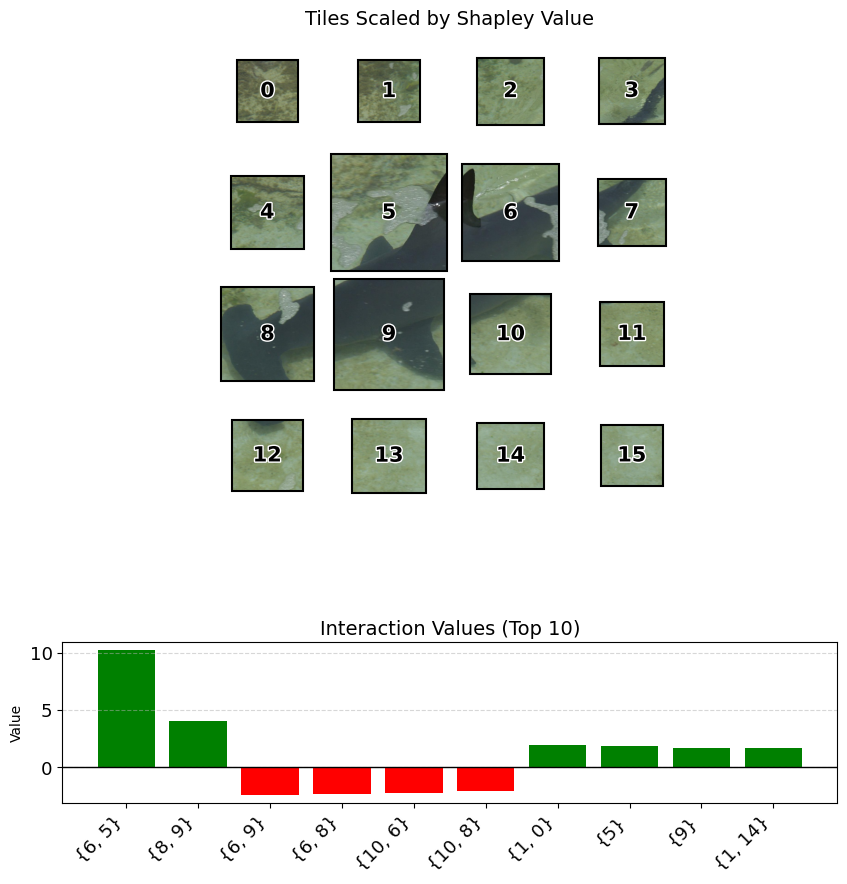

In [11]:
explanation.plot(mode="interaction")

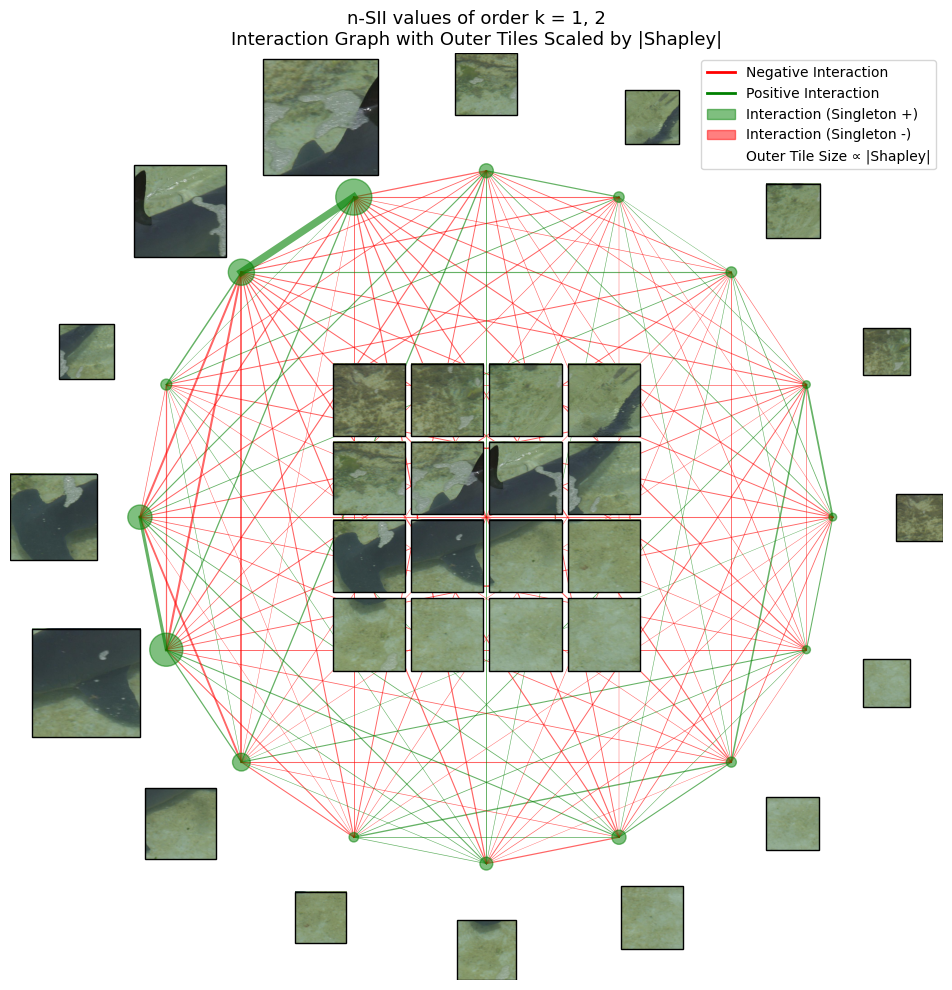

In [12]:
explanation.plot_circular_interaction_graph()

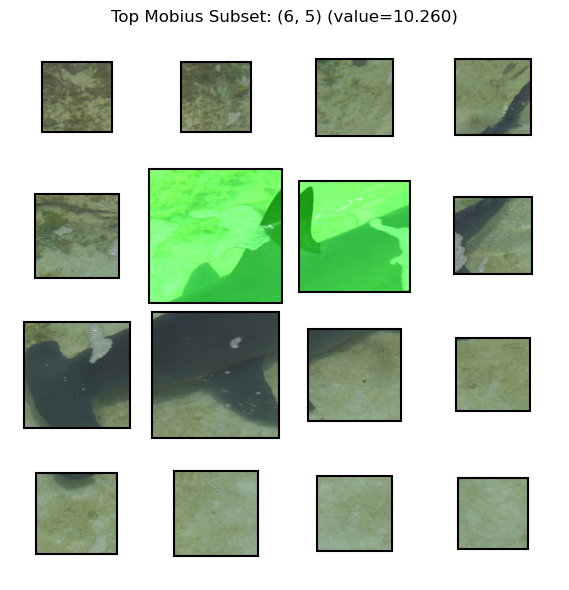

In [13]:
explanation.plot_top_mobius_tiles_scaled_by_shapley_safe()

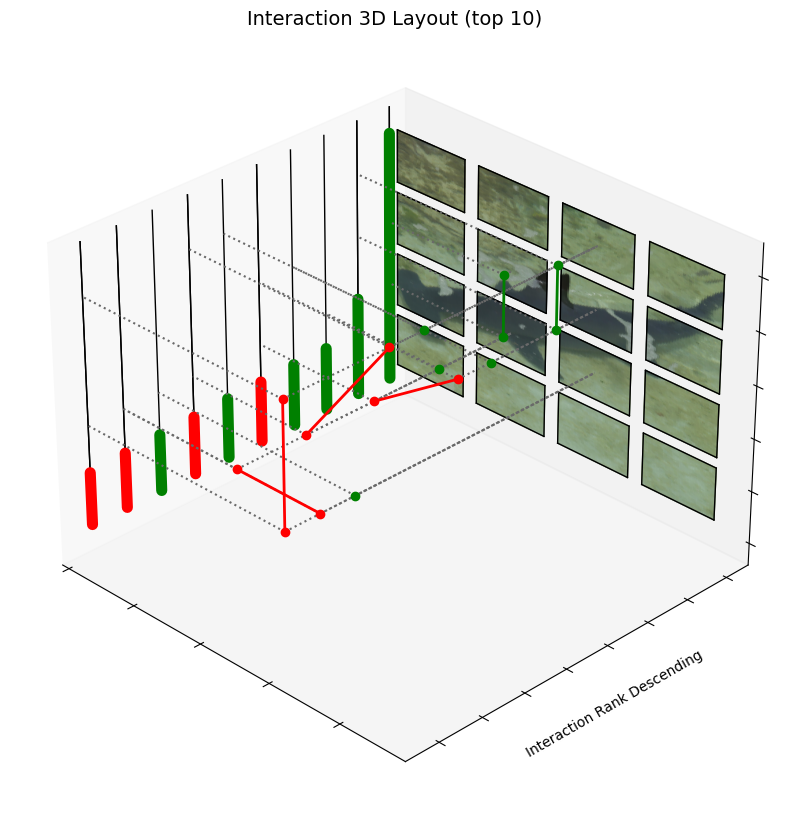

In [14]:
explanation.plot_interaction_3d_aligned(top_k=10)